# Understanding color tuning rules in human cellular retinol binding protein II
**The code in this notebook is based on an apporach by Karasuyama, M., Inoue, K., Nakamura, R. et al. Sci Rep 8, 15580 (2018)<p>
The mutant and WT absorption data for hCRBPII was extracted from Wenjing Wang et al. Science338,1340-1343 (2012).**



In [16]:
# Imports
import json
import time
import pickle
import numpy as np
from typing import Tuple
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from group_lasso import GroupLasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from src.notebook import one_hot_encode, get_seq, find_greedy_mutant, predict_new_maximum, one_hot


In [17]:
# Load the data
def load_data(raw_data: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray, str]:
    """Load the data from the json file and return the X, Y and groups arrays.
    
    Args:
        raw_data: Path, the path to the json file containing the data.
    Returns:
        X: np.ndarray, the one-hot encoded sequences.
        Y: np.ndarray, the lambda_max values.
        groups: np.ndarray, the groups for the group lasso (i.e. 20aa * N positions).
        wt_seq: str, the wild-type sequence.
    """

    # load the mutant json file
    with open(raw_data) as f:
        data = json.load(f)
    wt_seq = data["wt_seq"]
    mutant_dict = data["mutants"]
    
    # generate the dataset
    dataset = {get_seq(wt_seq, mutant):lambda_max for mutant, lambda_max in mutant_dict.items()}

    # now we encode the sequences as arrays with shape len(sequence) x 20 where for every position only one of the 20 entries is 1
    # and the rest are 0, this is called one-hot encoding

    seqs = [list(seq)for seq in dataset.keys()]
    X = np.array([[one_hot_encode(aa) for aa in seq] for seq in seqs])

    # X in dimension 1 and 2 needs to match the groups so we need to reshape X
    X = X.reshape(X.shape[0], -1)
    Y = np.array(list(dataset.values()))

    # Get the lasso groups of shape (len(sequence) x 20, 1)
    sequence_length = len(seqs[0])
    group_sizes = [20] * sequence_length
    groups = np.concatenate(
        [size * [i] for i, size in enumerate(group_sizes)]
    ).reshape(-1, 1)

    return X, Y, groups, wt_seq

# Training the model
def train_glasso(gamma: int, X: np.ndarray, Y: np.ndarray, 
                 groups: np.ndarray, random_seed=0, 
                 n_splits: int=10) -> Tuple[GroupLasso, float, float]:
    """Training the GroupLasso model with K-Fold cross-validation.
    
    Args:
        gamma: float, the regularization parameter
        X: np.array, the one-hot encoded sequences
        Y: np.array, the lambda_max values
        groups: np.array, the group indices
        n_splits: int, the number of splits for K-Fold cross-validation
    Returns:
        gl: GroupLasso, the trained model
        avg_mse: float, the average mean squared error
        avg_std: float, the average standard deviation
    """
    # Define the model
    gl = GroupLasso(groups=groups, group_reg=gamma, l1_reg=0, scale_reg=None, fit_intercept=True, n_iter=15000,\
                    tol=1e-8, warm_start=True, supress_warning=True, random_state=random_seed)

    # Use K-Fold cross-validation to evaluate the model
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_values = []
    std_values = []

    t_start = time.time()
    for k, (train_index, test_index) in enumerate(kf.split(X)):
        t_0 = time.time()
        # Split test and train data
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Fit the model
        gl.fit(X_train, Y_train)

        # Predict the test data and evaluate the model
        Y_pred = gl.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        std = np.std(Y_test - Y_pred)
        mse_values.append(mse)
        std_values.append(std)
        print(f"k={k}, MSE={round(mse)}, STD={round(std,2)}nm ({round(time.time()-t_0)}s)")

    print(f"Training done: avg. MSE={round(np.mean(mse_values))}, avg. STD={round(np.mean(std_values),2)}, with k={n_splits} in {round(time.time()-t_start)}s.")

    return gl, np.mean(mse_values), np.mean(std_values)

**Load the data and train the model!**

In [18]:
X, Y, groups, wt_seq = load_data("data/hcrbpII.json")

#gl, _, _ = train_glasso(0.11, X, Y, groups, n_splits=10)
#
## Save the model
#with open("data/group_lasso.pkl", "wb") as f:
#    pickle.dump(gl, f)

# Load the model
with open("data/group_lasso.pkl", "rb") as f:
    gl = pickle.load(f)

# Visualize the weights, learned by the model

Number of non-zero coefficients: 50


Text(0.5, 1.0, 'hCRBPII color-tuning substitutions')

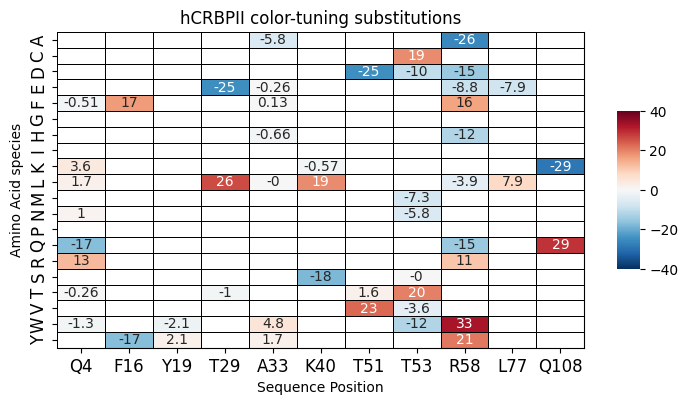

In [33]:
coefficients = gl.coef_
# Reshape to get the coefficients for position
coefficients = coefficients.reshape(133, 20)

# Get only positions with non-zero coefficients (should correspond to positions that were  mutated in the training data)
non_zero_positions = np.where(np.any(coefficients != 0, axis=1))[0]
non_zero_coefficients = coefficients[np.any(coefficients != 0, axis=1), :]

# Remove zero cells:
mask = non_zero_coefficients != 0
annotations = np.where(mask, non_zero_coefficients, np.nan)
annotations[mask] = np.round(non_zero_coefficients[mask], 2)
nan_mask = np.isnan(annotations)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8.5, 4.1))
sns.heatmap(np.round(non_zero_coefficients.T), ax=ax, cmap='RdBu_r', xticklabels=[wt_seq[i]+ str(i+1) for i in non_zero_positions],\
            vmin=-40, vmax=40,yticklabels=list(one_hot.keys()), cbar_kws={'shrink':0.5, 'aspect': 7,'ticks':[-40,-20,-0,20,40],}, \
            annot=annotations.T, mask=nan_mask.T, linewidth=.5, linecolor="black")
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Sequence Position')
plt.ylabel('Amino Acid species')
plt.title("hCRBPII color-tuning substitutions")

## Separating the individual comtributions
**These weights distribute the effect of a substitution equaly on the mutation and wt residue (e.g. Q108) <t>
To estimate the contributions of individual mutations we can substract the weight of the WT residue from <t>
that of all other non-zero contributions:**

Text(0.5, 1.0, 'hCRBPII color-tuning substitutions')

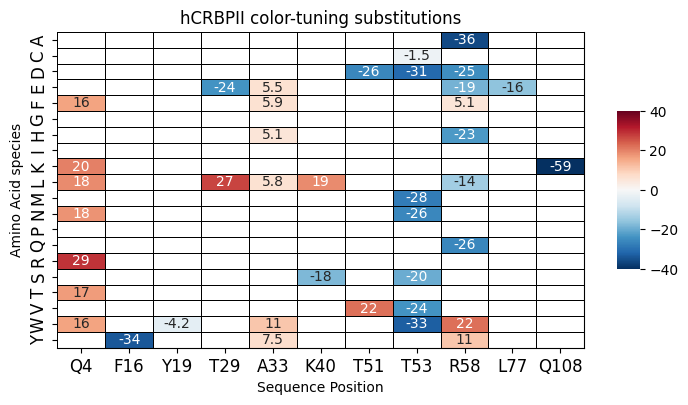

In [20]:
# now clean up the coefficients by substracting the value of the wild type residue at the position from all other non zero residues at that position

# get the wild type residues
wt_residues = np.asarray([one_hot_encode(aa) for aa in wt_seq])
# subtract the wild type residue from all other residues in the same position
for i, pos in enumerate(non_zero_positions):
    wt_residue = wt_residues[pos]
    wt_mask = wt_residue != 0
    substraction = non_zero_coefficients[i, wt_mask]
    mask = non_zero_coefficients[i, :] != 0
    non_zero_coefficients[i, mask] -= substraction

# recreate annotations
mask = non_zero_coefficients != 0
annotations = np.where(mask, non_zero_coefficients, np.nan)
annotations[mask] = np.round(non_zero_coefficients[mask], 2)
nan_mask = np.isnan(annotations)


# replot
fig, ax = plt.subplots(figsize=(8.5, 4.1))
sns.heatmap(np.round(non_zero_coefficients.T), ax=ax, cmap='RdBu_r', xticklabels=[wt_seq[i]+ str(i+1) for i in non_zero_positions],\
            vmin=-40, vmax=40,yticklabels=list(one_hot.keys()), cbar_kws={'shrink':0.5, 'aspect': 7,'ticks':[-40,-20,-0,20,40],}, \
            annot=annotations.T, mask=nan_mask.T, linewidth=.5, linecolor="black")
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Sequence Position')
plt.ylabel('Amino Acid species')
plt.title("hCRBPII color-tuning substitutions")

# We can use this table to design our own mutants
**The WT has an absorption maximum at 570nm, based on the table above, one can try to create a mutant with the desired absorption properties**

In [21]:
# We can test the viability of this approach with 2 structures with mutations that are resolved
# in the dataset but are not in the part of the training set

reference_mutants = {"Q108K:K40L:T51V:R58W:Y19W":577, # PDB ID 5FFH
                     "Q108K:K40L:T51V:T53C:Y19W:R58W:T29L:Q4A":614,} # PDB ID 4GKC

for mutant, ref_max in reference_mutants.items():
    pred_max = predict_new_maximum(gl, wt_seq, mutant)
    print(f"Mutant: {mutant}, Reference: {ref_max}, Prediction: {round(pred_max)}")

Mutant: Q108K:K40L:T51V:R58W:Y19W, Reference: 577, Prediction: 568
Mutant: Q108K:K40L:T51V:T53C:Y19W:R58W:T29L:Q4A, Reference: 614, Prediction: 610


### Now try picking your own colored mutant:
**Do this by applying the shifts from the plot above to reach your favorite color**

In [55]:
# Design a mutant with an absorption maximum of 430 nm!
my_mutant = "F16Y:Y19W:T29E:K40S:T51D:T53W"

# Get sequence and encode it
mutant_seq = get_seq(wt_seq, my_mutant)
X_mutant = np.array([[one_hot_encode(aa) for aa in mutant_seq]])    
X_mutant = X_mutant.reshape(X_mutant.shape[0], -1)

# Predict the absorption maximum
lambda_max = gl.predict(X_mutant)
print(f"Predicted lambda_max for mutant {my_mutant} is {round(lambda_max[0])} nm")

Predicted lambda_max for mutant F16Y:Y19W:T29E:K40S:T51D:T53W is 429 nm


### We can automate this task, using a gready algorithm on a graph
**This approach is based on the idea that we can construct a graph where the nodes are the mutations and the associated shifts are their corresponding weights. The graph is constructed by adding nodes for each mutation and edges between all nodes that are at different positions. <p>
The mutations leading to the target absorption maximum are then found using a greedy algorithm that keeps adding the mutation that brings the total shift closest to the target while removing the nodes at the same position.**

In [44]:
# Compute the mutant with the closest absorption maximum to 325 nm with a threshold of 3 nm
mutant_str, mutations, new_max = find_greedy_mutant(325, coefficients=coefficients, 
                                                    wt_seq=wt_seq, threshold=3, 
                                                    WT_wavelength=round(predict_new_maximum(gl, wt_seq, ":"))) # systematic shift in the WT model

print(f"Adding up the shifts of the mutations in the path:\n{mutations}\nleads to a predicted lambda_max of {round(new_max)} nm.")
print(f"Plugging the mutant into the model gives a lambda_max of {round(predict_new_maximum(gl, wt_seq, mutant_str))} nm")

    

Adding up the shifts of the mutations in the path:
Q108K(-59nm); R58A(-36nm); F16Y(-34nm); T53W(-33nm); T51D(-26nm); T29E(-24nm); K40S(-18nm); L77E(-16nm)
leads to a predicted lambda_max of 323 nm.
Plugging the mutant into the model gives a lambda_max of 322 nm
